In [10]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import glob
import os

#if youre using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#Some styling
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')

#Label encoder used to get a numeric representation of a label
le = preprocessing.LabelEncoder()

#The activities
LABELS = ['standing',
          'walking-natural',
          'walking-rider',
          'trotting-natural',
          'trotting-rider',
          'running-natural',
          'running-rider',
          'jumping',
          'grazing',
          'eating',
          'head shake',
          'shaking',
          'scratch-biting',
          'rubbing',
          'fighting',
          'rolling',
          'scared']

#Sliding windows
TIME_PERIODS = 80
STEP_DISTANCE = 40

#Datasets
PATH = '/content/drive/MyDrive/Bachelor GP/Let there be IMU data/datasets/JacobHorse/'
FILES = sorted(glob.glob(PATH + '*.csv'))

# Set up dataframe

In [12]:
REMOVE_COLUMNS = ['Mx', 'My', 'Mz','A3D','G3D','M3D'] #Add columns to drop from dataframe
def loadDataFrame(files):
    """
    Simple function to set up dataframe and initial clean-up of the data
    files: path to files
    returns: combined dataframe of all files
    """
    df = pd.DataFrame()
    for file in files:
        csv = pd.read_csv(file)
        csv['filename']=file.split('/')[8]
        df = df.append(csv)
        
    df.drop(REMOVE_COLUMNS, axis=1, inplace=True)
    df['ActivityEncoded'] = le.fit_transform(df['label'].values.ravel())

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


df = loadDataFrame(FILES)
df.head(10)



,Ax,Ay,Az,Gx,Gy,Gz,datetime,label,segment,filename,ActivityEncoded
0,6.5,-1.2,3.3,-12.8,54.2,-3.4,2018-06-14 20:06:48.0988,walking-natural,13935,subject_11_Patron_part_1.csv,15
1,6.6,-0.5,3.2,1.7,58.2,-6.8,2018-06-14 20:06:48.1088,walking-natural,13935,subject_11_Patron_part_1.csv,15
2,6.7,0.8,3.5,26.2,60.6,-8.1,2018-06-14 20:06:48.1188,walking-natural,13935,subject_11_Patron_part_1.csv,15
3,6.8,2.1,3.8,48.7,58.9,-8.8,2018-06-14 20:06:48.1288,walking-natural,13935,subject_11_Patron_part_1.csv,15
4,6.8,3.2,4.2,60.0,55.4,-9.1,2018-06-14 20:06:48.1388,walking-natural,13935,subject_11_Patron_part_1.csv,15
5,6.8,3.9,4.7,60.2,50.0,-8.2,2018-06-14 20:06:48.1488,walking-natural,13935,subject_11_Patron_part_1.csv,15
6,6.7,3.5,5.3,50.8,44.5,-6.9,2018-06-14 20:06:48.1588,walking-natural,13935,subject_11_Patron_part_1.csv,15
7,7.2,2.6,5.1,31.4,42.3,-4.8,2018-06-14 20:06:48.1688,walking-natural,13935,subject_11_Patron_part_1.csv,15
8,7.6,1.6,4.3,2.9,43.5,-2.3,2018-06-14 20:06:48.1788,walking-natural,13935,subject_11_Patron_part_1.csv,15
9,7.7,0.8,4.0,-18.1,48.6,1.5,2018-06-14 20:06:48.1888,walking-natural,13935,subject_11_Patron_part_1.csv,15


# Plot data composition

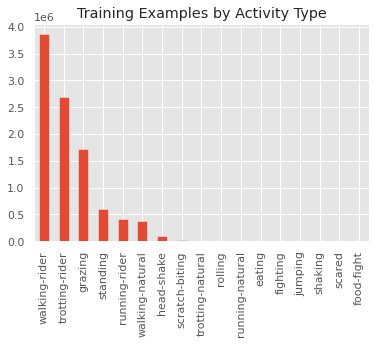

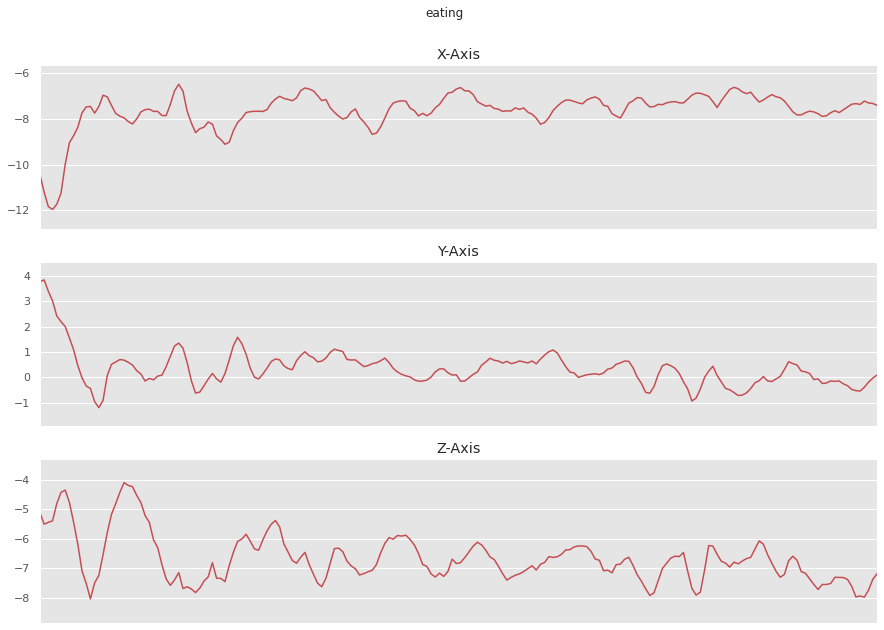

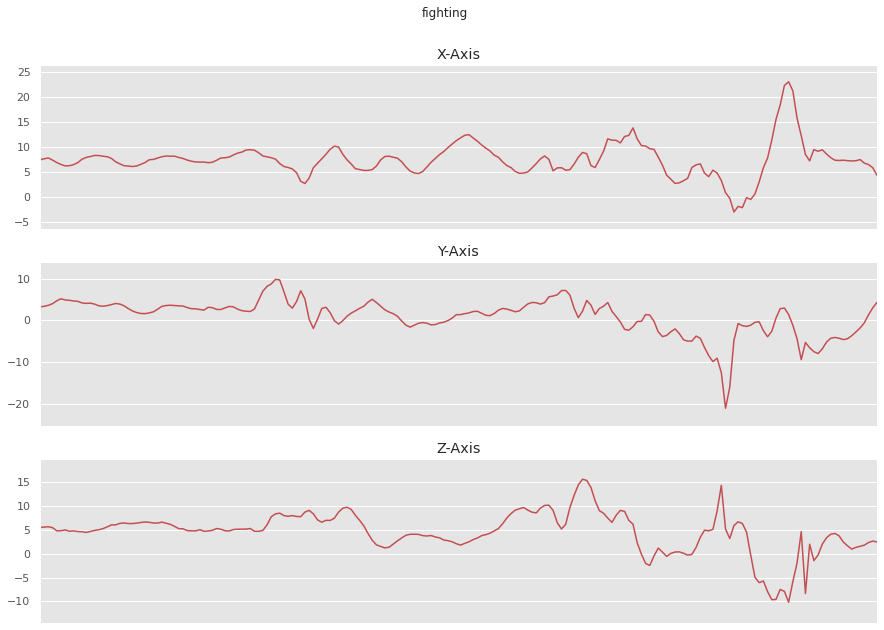

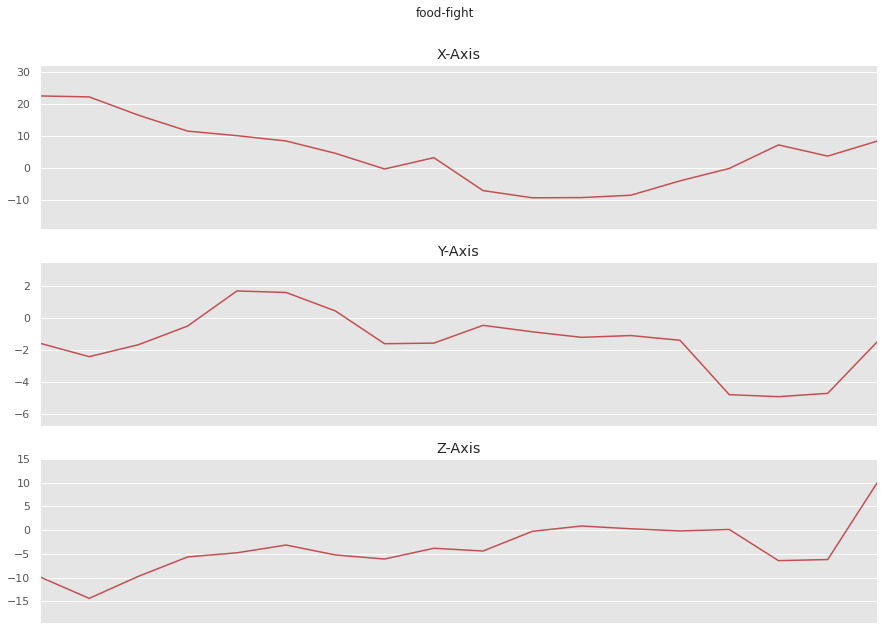

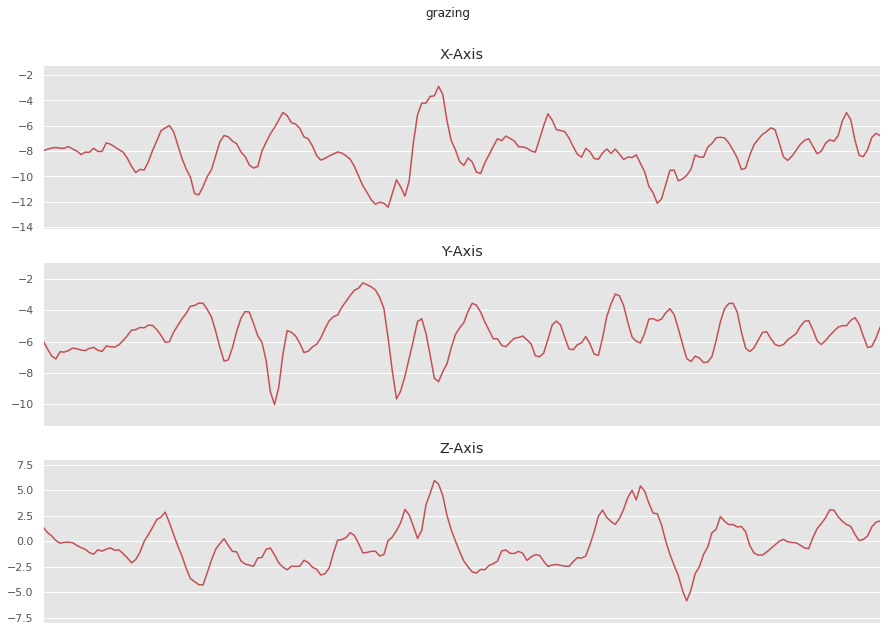

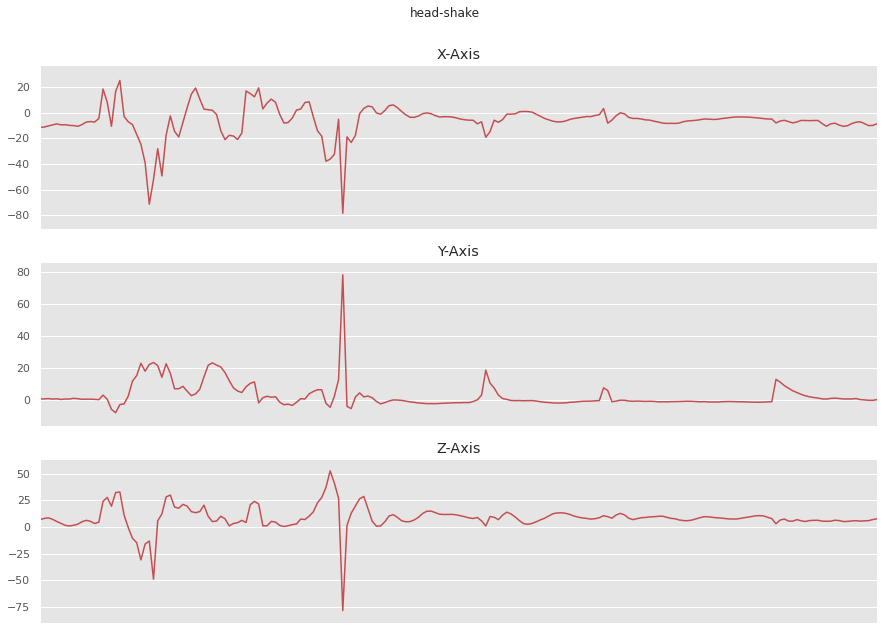

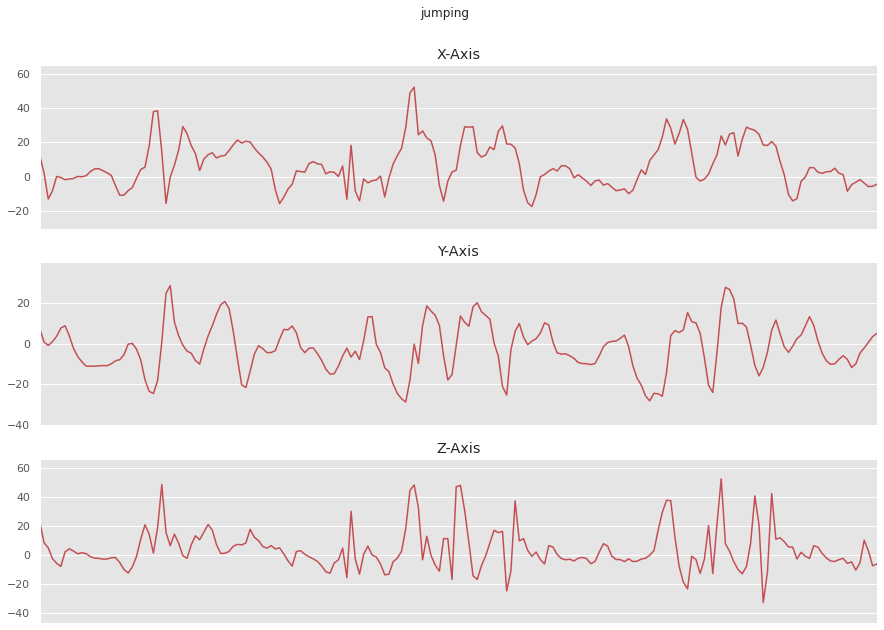

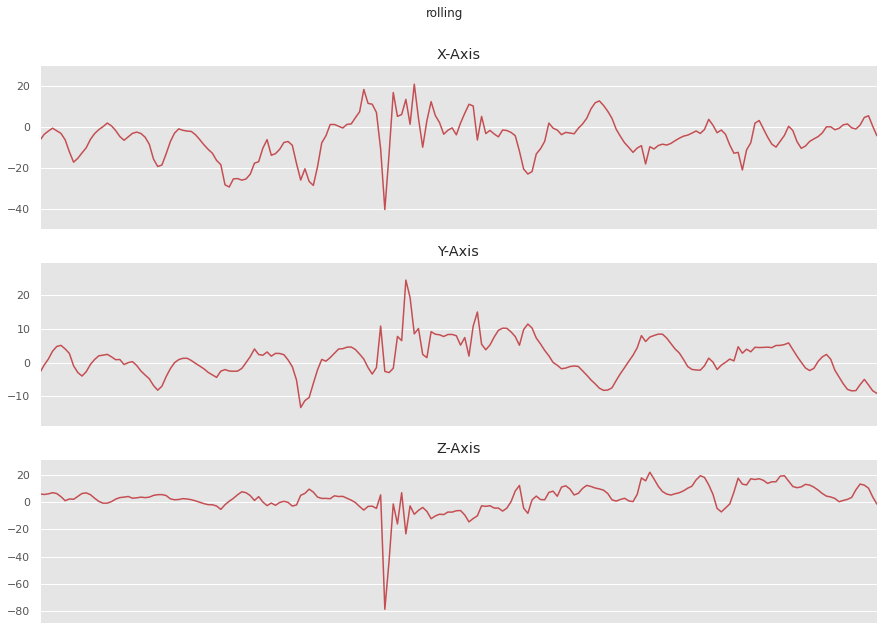

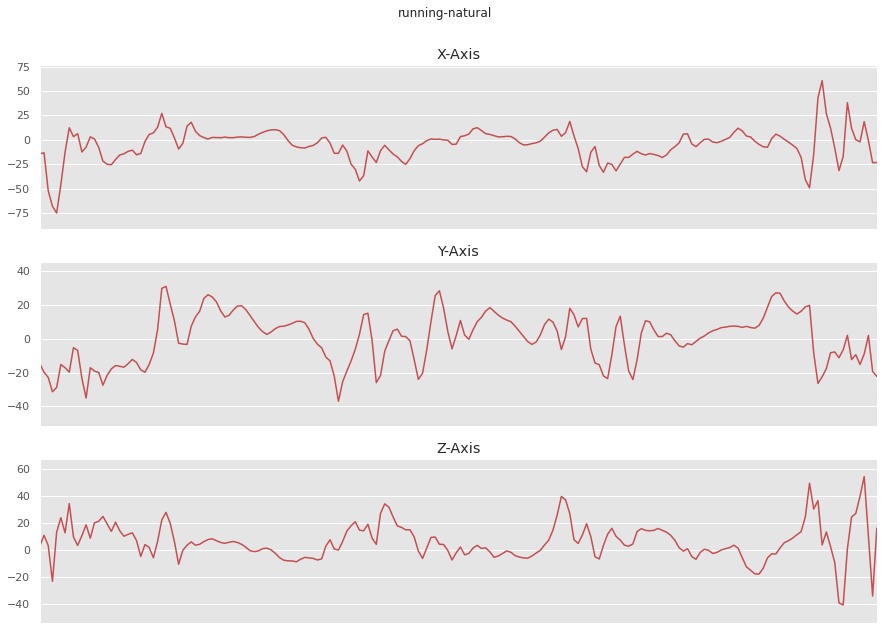

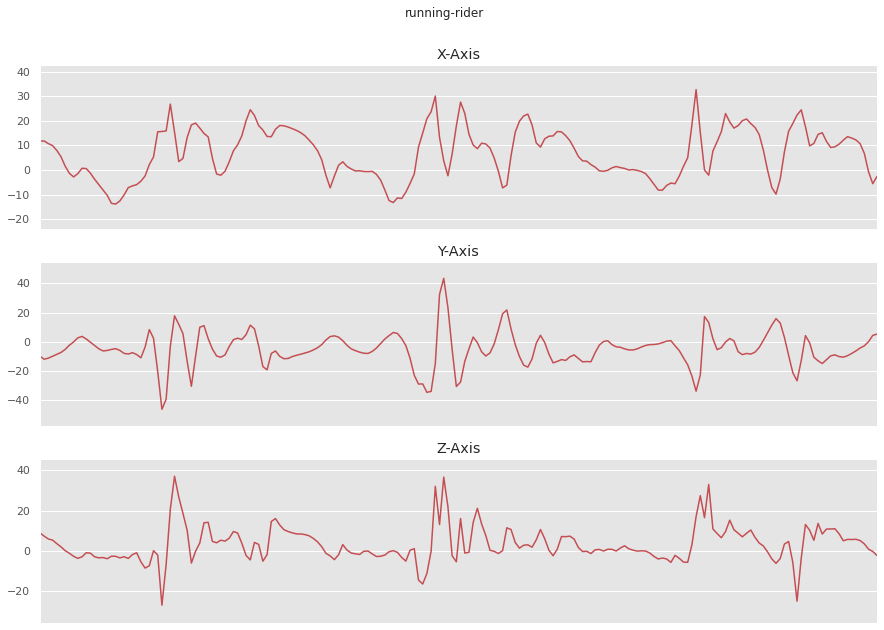

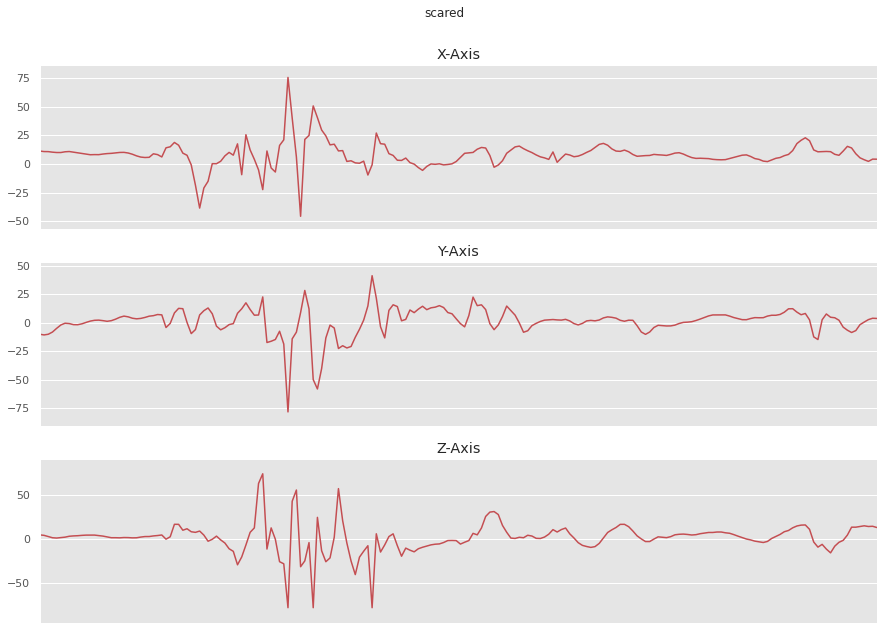

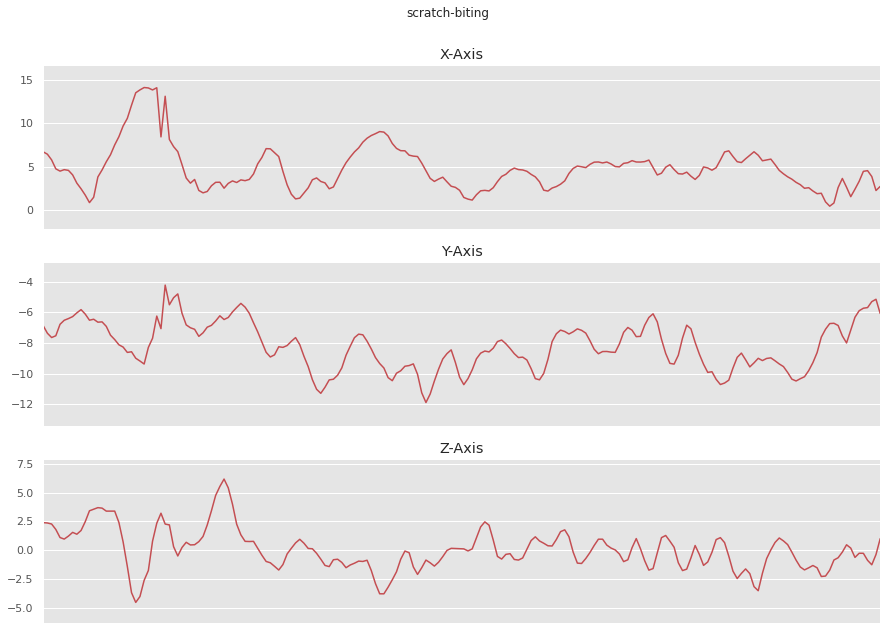

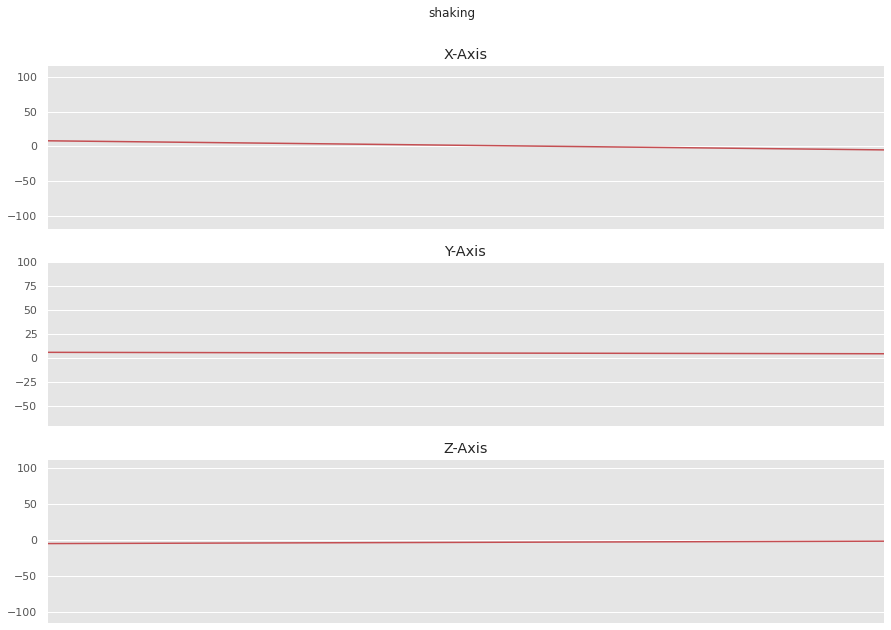

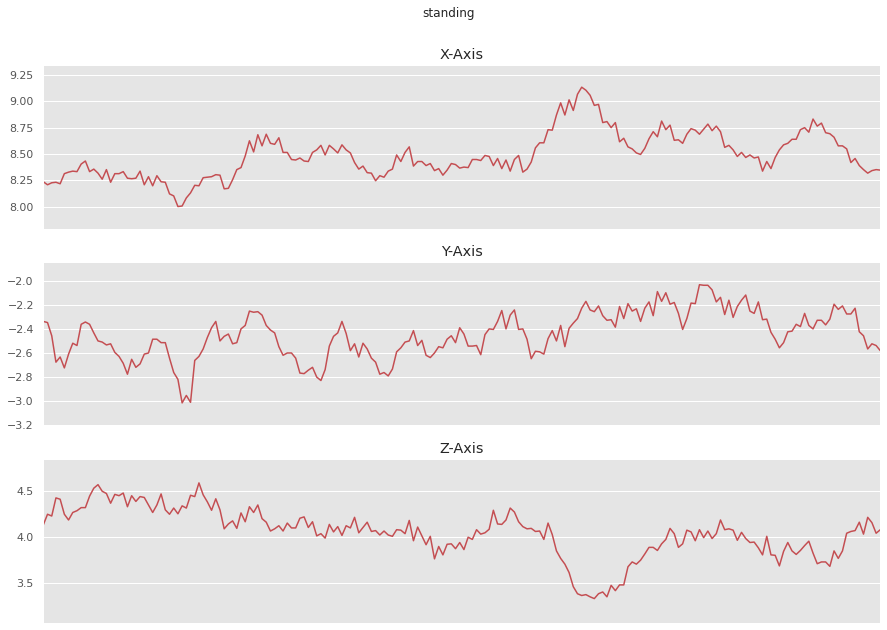

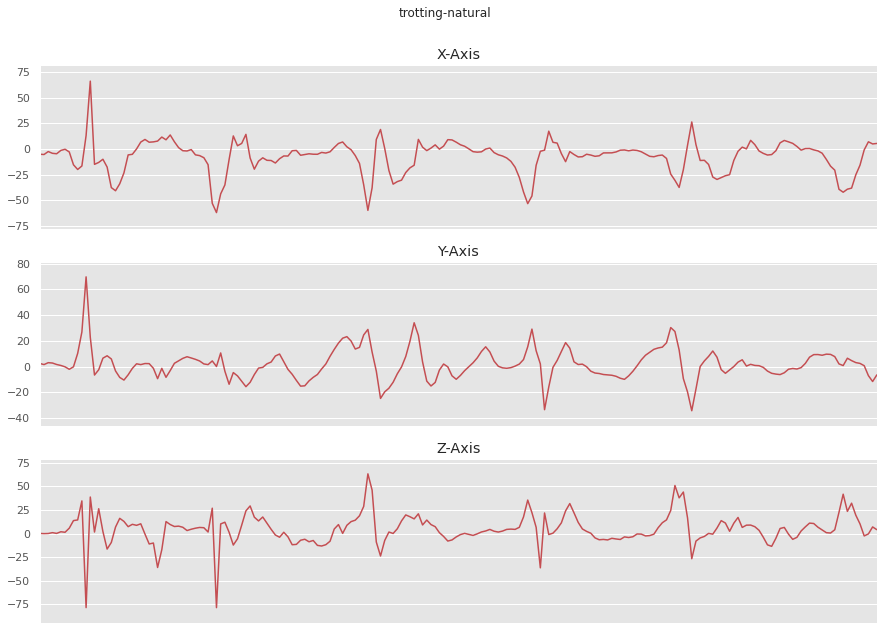

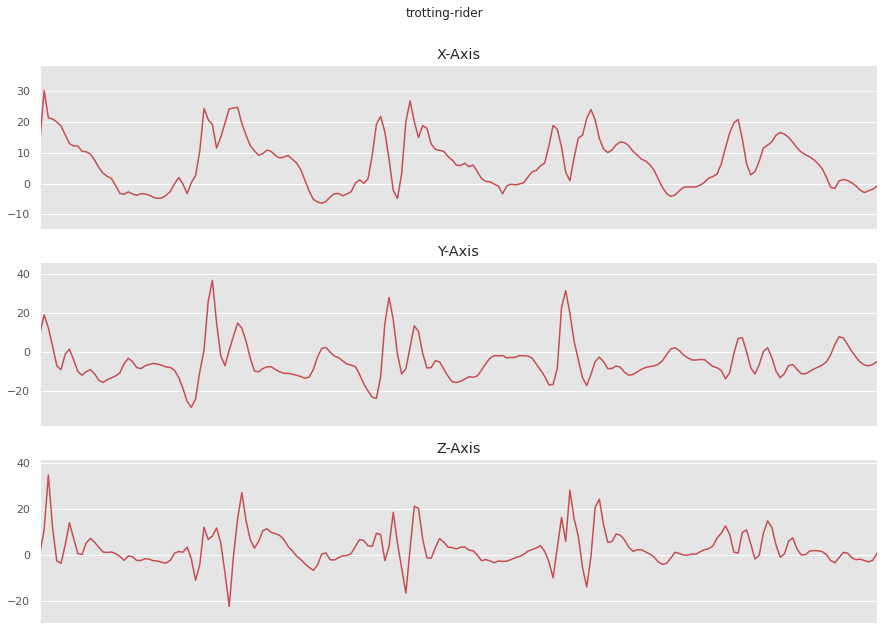

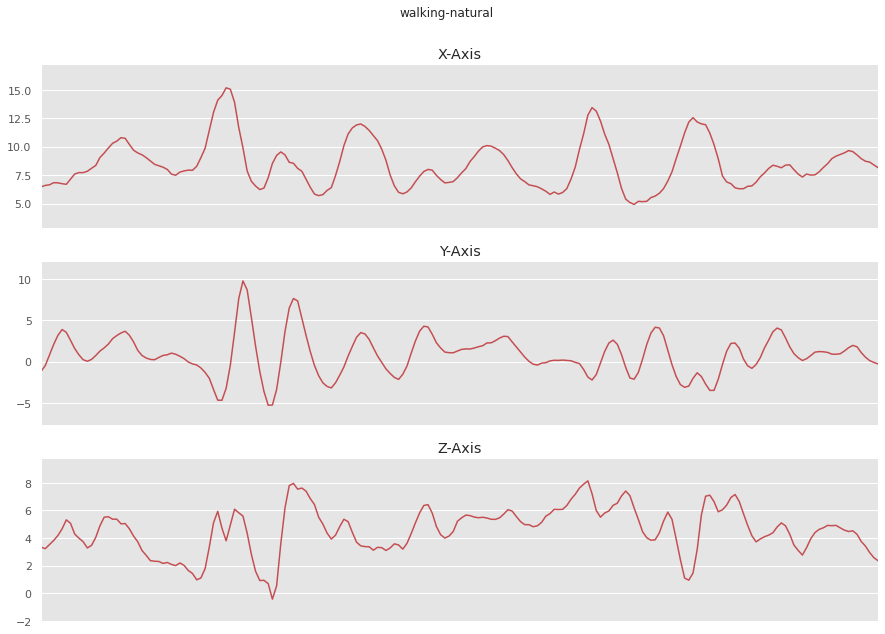

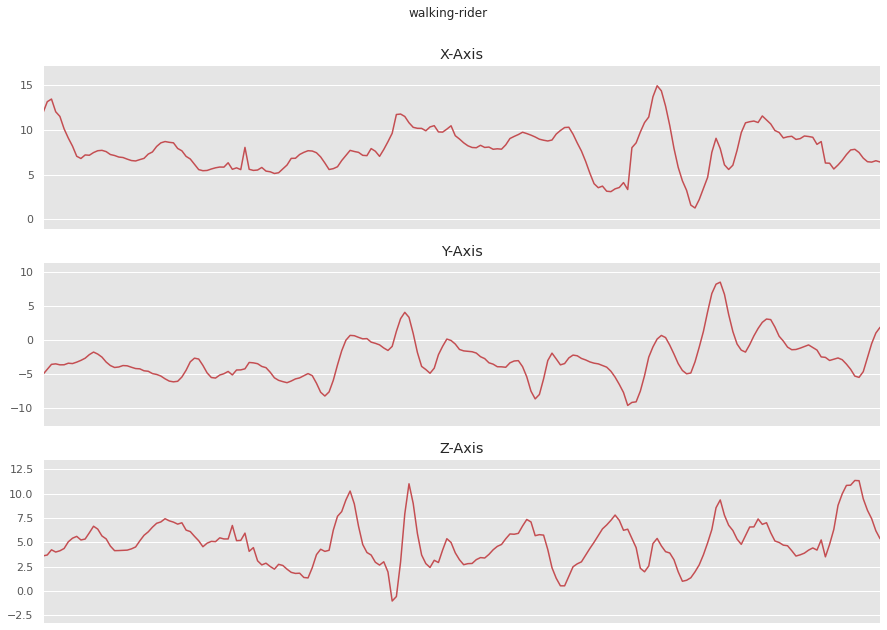

In [13]:

#Training examples per activity type
df['label'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()

SECONDS = 10 #nr of seconds to display accelerometer data
SAMPLING_RATE = 20 #the sampling rate at which data was recorded

def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['datetime'], data['Ax'], 'X-Axis')
    plot_axis(ax1, data['datetime'], data['Ay'], 'Y-Axis')
    plot_axis(ax2, data['datetime'], data['Az'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

#plot all 3 subplots for each activity
for activity in np.unique(df['label']):
    subset = df[df['label'] == activity][:SECONDS*SAMPLING_RATE] 
    plot_activity(activity, subset)

# Get only relevant subjects

In [ ]:
#Splitting the subjects on name and file
subjects = df.groupby(df.filename)

# csv files from relevant subjects
csv11 = [subjects.get_group('Data/subject_11_Patron_part_1.csv'), subjects.get_group('Data/subject_11_Patron_part_2.csv')]
csv8 = [subjects.get_group('Data/subject_8_Galoway_part_1.csv'), subjects.get_group('Data/subject_8_Galoway_part_2.csv'), subjects.get_group('Data/subject_8_Galoway_part_3.csv')]
csv14 = [subjects.get_group('Data/subject_14_Bacardi_part_1.csv')]
csv7 = [subjects.get_group('Data/subject_7_Driekus_part_1.csv'), subjects.get_group('Data/subject_7_Driekus_part_2.csv')]
csv2 = [subjects.get_group('Data/subject_2_Happy_part_1.csv'), subjects.get_group('Data/subject_2_Happy_part_2.csv'), subjects.get_group('Data/subject_2_Happy_part_3.csv')]

# Create 1 dataframe for each relevant subject
patron = pd.concat(csv11)
galoway = pd.concat(csv8)
bacardi = pd.concat(csv14)
driekus = pd.concat(csv7)
happy = pd.concat(csv2)



horses = [patron, galoway, bacardi, driekus, happy]
NUM_HORSES = len(horses)

# Splitting test and trainig sets    
for i in range(NUM_HORSES):
    
    test_horse = horses[i]
    others = horses[:i]
    others.extend(horses[i+1:])
    train_horses = pd.concat(others)
    
    print(f"\n\nTest: {test_horse['filename'].unique()}")
    
    print(f"Train horses {train_horses['filename'].unique()}")
    

    
    


# Shuffle data

In [ ]:
#shuffling the whole dataframe
def shuffle(data_frame):
    return data_frame.sample(frac=1).reset_index(drop=True)


# Splitting

In [ ]:
# Splitting

# Feature scaling

In [ ]:
#divide all 3 axis with the max value in the training set
train['Ax'] = train['Ax'] / train['Ax'].max()
train['Ay'] = train['Ay'] / train['Ay'].max()
train['Az'] = train['Az'] / train['Az'].max()

#divide all 3 axis with the max value in the training set
test['Ax'] = train['Ax'] / train['Ax'].max()
test['Ay'] = train['Ay'] / train['Ay'].max()
test['Az'] = train['Az'] / train['Az'].max()



# Round numbers up to 5 decimal spaces
train = train.round({'Ax': 5, 'Ay': 5, 'Az': 5})
test = test.round({'Ax': 5, 'Ay': 5, 'Az': 5})


# Segmentation

In [ ]:
LABEL = 'ActivityEncoded'

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['Ax'].values[i: i + time_steps]
        ys = df['Ay'].values[i: i + time_steps]
        zs = df['Az'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(train, TIME_PERIODS, STEP_DISTANCE, LABEL)
x_test, y_test = create_segments_and_labels(test, TIME_PERIODS, STEP_DISTANCE, LABEL)

#set dimension of input and output
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size

# Flattening to one dimention

In [ ]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_test = x_test.reshape(x_test.shape[0], input_shape)

# Apply one-hot coding

In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [ ]:
float(df['Az'].head(1))

In [ ]:
ds = []
for d in df['Az']:
    try:
         ds.append(float(d))
    except ValueError:
        pass

#Set up Neural Network

##model architecture

In [ ]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

##Hyperparameters

In [ ]:
BATCH_SIZE = 400
EPOCHS = 50
VALIDATION_SIZE = 0.2

#Training the model

In [ ]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model_m.fit(x_train, 
                      y_train_hot, 
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=VALIDATION_SIZE,
                      verbose=1)

#Check performance on test data

In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)


max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))